In [1]:
import backtrader as bt
import pandas as pd


class Portfolio(bt.Strategy):
    def __init__(self):
        self.values = []  # 포트폴리오 가치 저장 리스트
        
    def start(self):
        pass

    def next(self):
        if len(self.values) == 0:  # 첫 next()에서만 매수
            cash = self.broker.get_cash()
            brazil_bond_size = (cash / 3) / self.datas[0].close[0]
            brl_usd_size = (cash / 3) / self.datas[1].close[0] 
            krw_usd_size = (cash / 3) / self.datas[2].close[0]

            self.buy(data=self.datas[0], size=brazil_bond_size)
            self.sell(data=self.datas[1], size=brl_usd_size)
            self.buy(data=self.datas[2], size=krw_usd_size)

        # 현재 포트폴리오 가치 계산 및 저장
        current_value = self.broker.getvalue()
        self.values.append(current_value)
        
        # 디버깅을 위해 현재 가치 출력
        print(f"Date: {self.datetime.date()}, Portfolio Value: {current_value:.2f}")


In [2]:
import pandas as pd
import backtrader as bt
from datetime import datetime
from matplotlib import pyplot as plt

# 예시: 자산 1의 Pandas DataFrame
brazil_bond = pd.read_csv('brazil_bond_prices_by_krw.csv', parse_dates=True, index_col='Date')
brl_usd = pd.read_csv('brl_usd_by_krw_contract_size.csv', parse_dates=True, index_col='Date')
krw_usd = pd.read_csv('krw_usd_by_contract_size.csv', parse_dates=True, index_col='Date')


# 모든 날짜의 합집합 구하기
all_dates = brazil_bond.index.union(brl_usd.index).union(krw_usd.index)

# 모든 데이터프레임을 합집합 날짜로 재인덱싱하고 이전 값으로 채우기
brazil_bond = brazil_bond.reindex(all_dates)
brazil_bond = brazil_bond.ffill()
brazil_bond = brazil_bond.bfill()

brl_usd = brl_usd.reindex(all_dates)
brl_usd = brl_usd.ffill()
brl_usd = brl_usd.bfill()


krw_usd = krw_usd.reindex(all_dates)
krw_usd = krw_usd.ffill()
krw_usd = krw_usd.bfill()




In [3]:

# Cerebro 엔진에 데이터 추가
from_date = datetime(2024, 10, 11)  # 시작 날짜 (예시)
to_date = datetime(2025, 4, 11)  # 끝 날짜 (예시)

brazil_bond = brazil_bond[(brazil_bond.index >= from_date) & (brazil_bond.index <= to_date)]
brl_usd = brl_usd[(brl_usd.index >= from_date) & (brl_usd.index <= to_date)]
krw_usd = krw_usd[(krw_usd.index >= from_date) & (krw_usd.index <= to_date)]

In [4]:
brazil_bond

,Close
Date,
2024-10-11,229034.684362
2024-10-13,229034.684362
2024-10-14,227665.570002
2024-10-15,229895.870465
2024-10-16,228575.523071
...,...
2025-04-07,249372.344464
2025-04-08,248292.817340
2025-04-09,246955.794747


In [5]:
brl_usd


,Close
Date,
2024-10-11,4.332286e+06
2024-10-13,4.332286e+06
2024-10-14,4.283291e+06
2024-10-15,4.336234e+06
2024-10-16,4.267258e+06
...,...
2025-04-07,4.276438e+06
2025-04-08,4.203380e+06
2025-04-09,4.109898e+06


In [6]:
krw_usd

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-10-11,0.000741,0.000740,0.000744,92610.429345,inf,inf,inf
2024-10-13,0.000741,0.000740,0.000744,92610.429345,inf,inf,inf
2024-10-14,0.000742,0.000735,0.000742,92707.277947,inf,inf,inf
2024-10-15,0.000737,0.000733,0.000737,92096.633832,inf,inf,inf
2024-10-16,0.000734,0.000732,0.000736,91697.351102,inf,inf,inf
...,...,...,...,...,...,...,...
2025-04-07,0.000686,0.000680,0.000688,85703.314542,inf,inf,inf
2025-04-08,0.000680,0.000675,0.000682,85036.908842,inf,inf,inf
2025-04-09,0.000673,0.000673,0.000680,84111.080181,inf,inf,inf


In [7]:
cash = 100000000000
pd.set_option('display.float_format', '{:.4f}'.format)

portfolio = pd.DataFrame(index=all_dates, columns=['brazil_bond', 'brl_usd', 'krw_usd'])
portfolio['brazil_bond'] = brazil_bond['Close']
portfolio['brl_usd'] = brl_usd['Close']
portfolio["brl_usd_sell_prod"] = 1 + (portfolio["brl_usd"].pct_change() * -1)
portfolio["brl_usd_sell_prod"].iloc[0] = brl_usd["Close"].iloc[0]
portfolio["brl_usd_sell"] = portfolio["brl_usd_sell_prod"].cumprod()

portfolio['krw_usd'] = krw_usd['Close']


portfolio["brazil_bond_size"] = int((cash / 3) / portfolio["brazil_bond"].iloc[0])
portfolio["brl_usd_size"] = int((cash / 3) / portfolio["brl_usd"].iloc[0])


portfolio["krw_usd_size"] = int((cash / 3) / portfolio["krw_usd"].iloc[0])

portfolio["brazil_bond_portfolio"] = portfolio["brazil_bond_size"] * portfolio["brazil_bond"]
portfolio["brl_krw_portfolio"] = portfolio["brl_usd_size"] * portfolio["brl_usd_sell"] + portfolio["krw_usd_size"] * portfolio["krw_usd"]
portfolio["net_portfolio"] = portfolio["brazil_bond_portfolio"] + portfolio["brl_krw_portfolio"]
portfolio


/var/folders/bs/f41tt40n4051glsbp8qq036c0000gp/T/ipykernel_82175/3961005078.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  portfolio["brl_usd_sell_prod"].iloc[0] = brl_usd["Close"].iloc[0]
/var/folders/bs/f41tt40n4051glsbp8qq036c0000gp/

,brazil_bond,brl_usd,krw_usd,brl_usd_sell_prod,brl_usd_sell,brazil_bond_size,brl_usd_size,krw_usd_size,brazil_bond_portfolio,brl_krw_portfolio,net_portfolio
Date,,,,,,,,,,,
2024-10-11,229034.6844,4332286.3821,92610.4293,4332286.3821,4332286.3821,145538,7694,359930,33333249892.7249,66665883258.3413,99999133151.0662
2024-10-13,229034.6844,4332286.3821,92610.4293,1.0000,4332286.3821,145538,7694,359930,33333249892.7249,66665883258.3413,99999133151.0662
2024-10-14,227665.5700,4283290.8896,92707.2779,1.0113,4381281.8747,145538,7694,359930,33133991726.9714,67077713295.2287,100211705022.2001
2024-10-15,229895.8705,4336233.6029,92096.6338,0.9876,4327127.9645,145538,7694,359930,33458585195.7594,66441263973.9534,99899849169.7128
2024-10-16,228575.5231,4267258.2241,91697.3511,1.0159,4395958.5022,145538,7694,359930,33266424476.6502,66827132297.8155,100093556774.4657
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-07,249372.3445,4276438.2925,85703.3145,1.0654,4191804.0009,145538,7694,359930,36293152268.6364,63098933986.1878,99392086254.8242
2025-04-08,248292.8173,4203380.0867,85036.9088,1.0171,4263416.3237,145538,7694,359930,36136040050.0891,63410059794.2853,99546099844.3744
2025-04-09,246955.7947,4109898.2388,84111.0802,1.0222,4358233.3586,145538,7694,359930,35941452455.8866,63806348550.7281,99747801006.6147


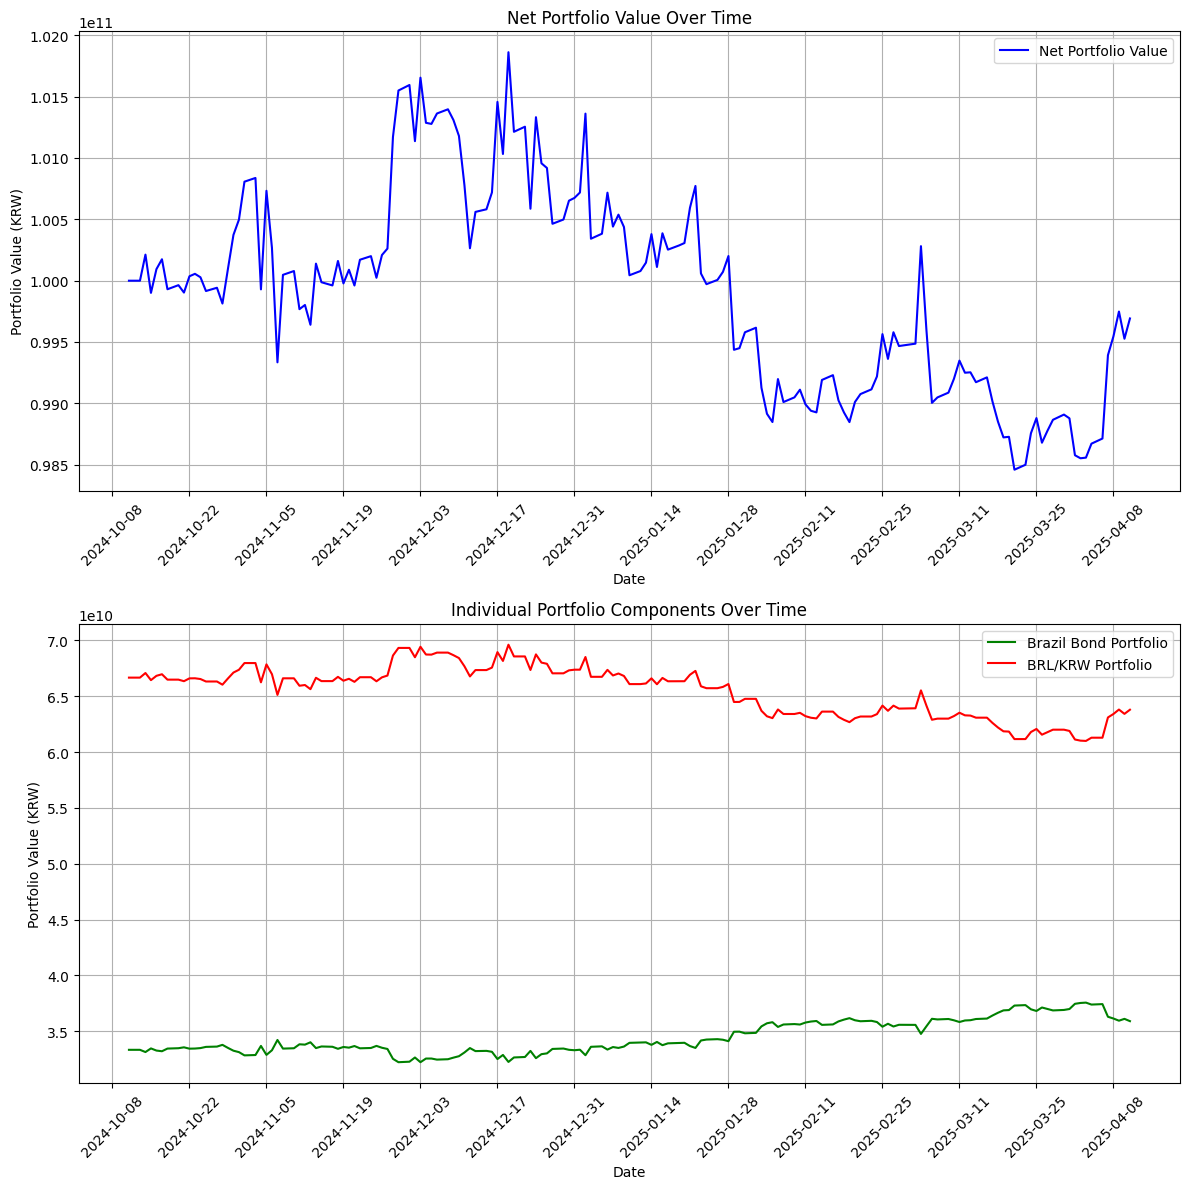

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot net portfolio value in the first subplot
ax1.plot(portfolio.index, portfolio['net_portfolio'], label='Net Portfolio Value', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value (KRW)')
ax1.set_title('Net Portfolio Value Over Time')
ax1.grid(True)
ax1.legend()

# Format the x-axis to show dates properly for the first subplot
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Plot individual portfolio components in the second subplot
ax2.plot(portfolio.index, portfolio['brazil_bond_portfolio'], label='Brazil Bond Portfolio', color='green')
ax2.plot(portfolio.index, portfolio['brl_krw_portfolio'], label='BRL/KRW Portfolio', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Portfolio Value (KRW)')
ax2.set_title('Individual Portfolio Components Over Time')
ax2.grid(True)
ax2.legend()

# Format the x-axis to show dates properly for the second subplot
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


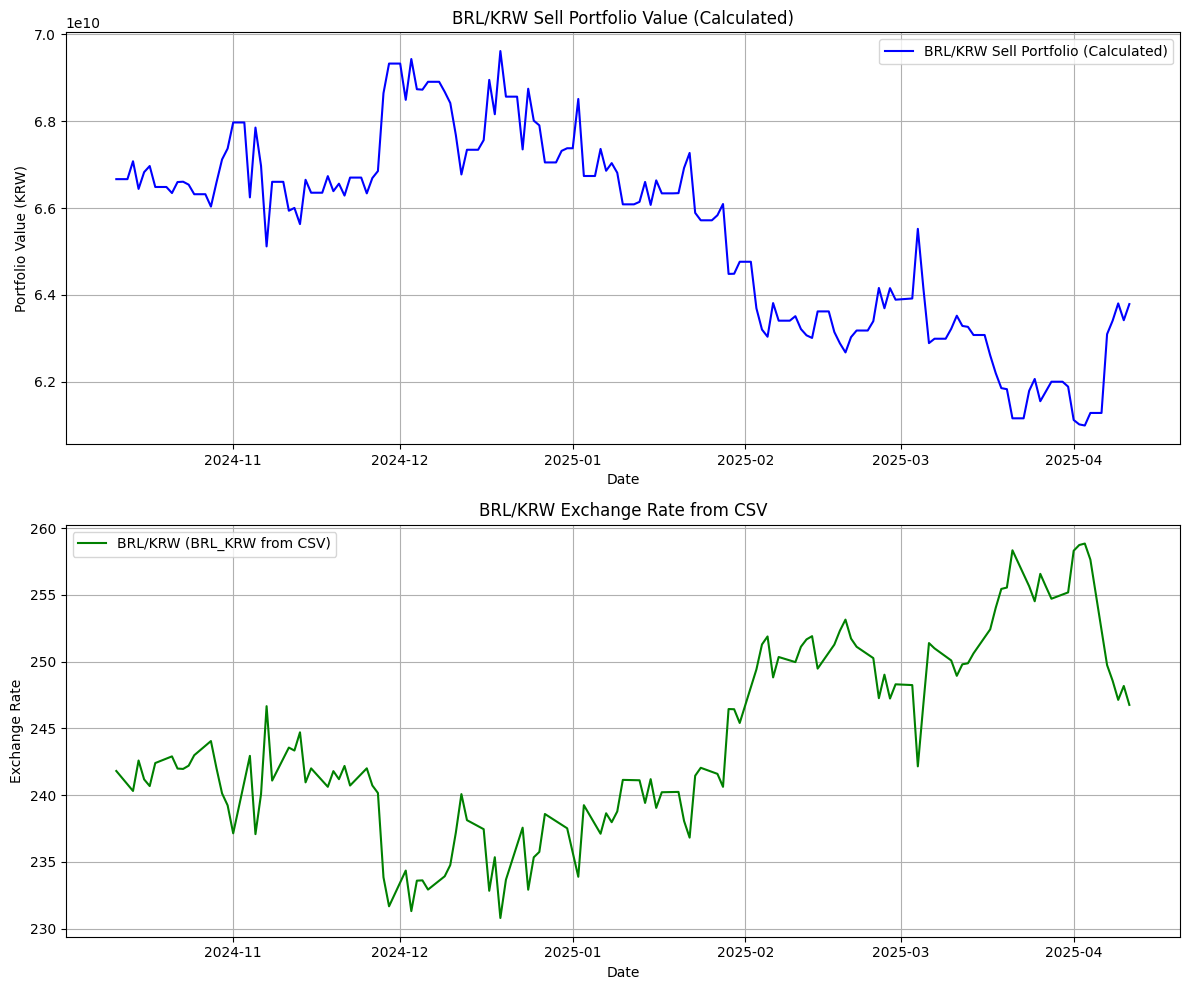

An error occurred: Passing a set as an indexer is not supported. Use a list instead.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the BRL/KRW data from the CSV file
# Assuming the file exists in the same directory as the notebook
try:
    brl_krw_data = pd.read_csv('brl_krw.csv', index_col='Date', parse_dates=True)
    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot the brl_krw_portfolio from our portfolio dataframe
    ax1.plot(portfolio.index, portfolio['brl_krw_portfolio'], label='BRL/KRW Sell Portfolio (Calculated)', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value (KRW)')
    ax1.set_title('BRL/KRW Sell Portfolio Value (Calculated)')
    ax1.grid(True)
    ax1.legend()
    
    # Plot the BRL/KRW data from the CSV file
    if 'Close' in brl_krw_data.columns:
        ax2.plot(brl_krw_data.index, brl_krw_data['Close'], label='BRL/KRW Exchange Rate (CSV)', color='green')
    else:
        # If 'Close' column doesn't exist, use the first available column
        column_name = brl_krw_data.columns[0]
        ax2.plot(brl_krw_data.index, brl_krw_data[column_name], label=f'BRL/KRW ({column_name} from CSV)', color='green')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Exchange Rate')
    ax2.set_title('BRL/KRW Exchange Rate from CSV')
    ax2.grid(True)
    ax2.legend()
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation if date ranges overlap
    common_dates = set(portfolio.index).intersection(set(brl_krw_data.index))
    if common_dates:
        portfolio_subset = portfolio.loc[common_dates, 'brl_krw_portfolio']
        
        if 'Close' in brl_krw_data.columns:
            brl_krw_subset = brl_krw_data.loc[common_dates, 'Close']
        else:
            column_name = brl_krw_data.columns[0]
            brl_krw_subset = brl_krw_data.loc[common_dates, column_name]
        
        correlation = portfolio_subset.corr(brl_krw_subset)
        print(f"Correlation between brl_krw_portfolio and BRL/KRW CSV data: {correlation:.4f}")
        
        # Display the first few rows of both datasets for comparison
        comparison_df = pd.DataFrame({
            'brl_krw_portfolio': portfolio_subset,
            'brl_krw_csv': brl_krw_subset
        }).sort_index()
        
        print("\nComparison of the first 5 rows:")
        print(comparison_df.head())
        
except FileNotFoundError:
    print("Error: brl_krw.csv file not found. Please make sure the file exists in the correct location.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


In [ ]:

# # Pandas DataFrame을 Backtrader Data Feed로 변환
# brazil_bond = bt.feeds.PandasData(dataname=brazil_bond)
# brl_usd = bt.feeds.PandasData(dataname=brl_usd)
# krw_usd = bt.feeds.PandasData(dataname=krw_usd)

# cerebro = bt.Cerebro()
# cerebro.addstrategy(Portfolio)
# cerebro.adddata(brazil_bond)
# cerebro.adddata(brl_usd)
# cerebro.adddata(krw_usd)


In [ ]:
# # 초기 자본 설정
# # 1000,0000,0000
# seed = 10000000000000
# cerebro.broker.set_cash(seed)
# # 전략을 추가하고 실행
# results = cerebro.run()

In [12]:
# strategy = results[0]

In [ ]:
# strategy.values

In [ ]:
# # ✅ 포트폴리오 가치 그래프 출력
# plt.figure(figsize=(12, 6))
# plt.plot(strategy.values[1:], label="Portfolio Value", color="blue")
# plt.xlabel("Time")
# plt.ylabel("Portfolio Value")
# plt.title("Portfolio Value Over Time")
# plt.legend()
# plt.grid()
# # Get dates from data for x-axis
# dates = data1.datetime.array
# # Convert numeric dates to datetime format
# formatted_dates = [bt.num2date(d) for d in dates]
# # Set x-ticks to show dates with fewer ticks (every 10 days)
# tick_interval = 10  # Show a date every 10 data points
# tick_positions = range(0, len(strategy.values[1:]), tick_interval)
# tick_labels = [formatted_dates[i+1].strftime('%Y-%m-%d') for i in tick_positions if i+1 < len(formatted_dates)]
# plt.xticks(tick_positions, tick_labels, rotation=45)
# plt.tight_layout()  # Adjust layout to make room for rotated date labels

# plt.show()

In [15]:
# # 최종 자산 가치 출력
# print(f'Final Portfolio Value: {cerebro.broker.getvalue()}')

# # total return
# total_return = (cerebro.broker.getvalue() - strategy.values[1]) / strategy.values[1]
# print(f'Total Return: {total_return}')